# Quickstart


In [13]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-openai

In [14]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [15]:
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, MessageGraph

model = ChatOpenAI(temperature=0)

graph = MessageGraph()

graph.add_node("oracle", model)
graph.add_edge("oracle", END)

graph.add_edge(START, "oracle")

runnable = graph.compile()

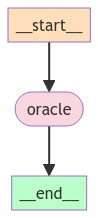

In [16]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
runnable.invoke(HumanMessage("What is 1 + 1?"))

[HumanMessage(content='What is 1 + 1?', id='bb29f237-0e4d-4354-92e1-d46434c67fe7'),
 AIMessage(content='1 + 1 equals 2.', response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-2ff0112a-9402-44a1-a992-c44fb49fa894-0', usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23})]

In [18]:
from typing import Literal

from langchain_core.tools import tool

from langgraph.graph import END, START
from langgraph.prebuilt import ToolNode


@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number


model = ChatOpenAI(temperature=0)
model_with_tools = model.bind_tools(tools=[multiply])

graph = MessageGraph()

graph.add_node("oracle", model_with_tools)

tool_node = ToolNode([multiply])
graph.add_node("multiply", tool_node)
graph.add_edge(START, "oracle")
graph.add_edge("multiply", END)


def router(state: list[BaseMessage]) -> Literal["multiply", "__end__"]:
    tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return END


graph.add_conditional_edges("oracle", router)
runnable = graph.compile()

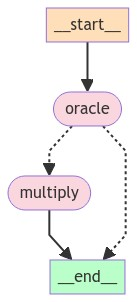

In [19]:
try:
    display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
runnable.invoke(HumanMessage("What is 123 * 456?"))

[HumanMessage(content='What is 123 * 456?', id='fa2dbb36-c61b-4ce1-892d-c08f3e741035'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZpoO6ClLFKkppN9Y8GEelZH1', 'function': {'arguments': '{"first_number":123,"second_number":456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 57, 'total_tokens': 76}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ee9faec5-3526-45d5-89b1-5292755a6893-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': 'call_ZpoO6ClLFKkppN9Y8GEelZH1'}], usage_metadata={'input_tokens': 57, 'output_tokens': 19, 'total_tokens': 76}),
 ToolMessage(content='56088', name='multiply', id='b9992170-ca76-4256-8560-29b329c1b56e', tool_call_id='call_ZpoO6ClLFKkppN9Y8GEelZH1')]

In [21]:
runnable.invoke(HumanMessage("What is your name?"))

[HumanMessage(content='What is your name?', id='09f03ac4-ca68-4464-9ec3-2c393699b3bb'),
 AIMessage(content='My name is Assistant. How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 54, 'total_tokens': 67}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-a21b2f58-3fa6-428f-99e5-9c4e071a9319-0', usage_metadata={'input_tokens': 54, 'output_tokens': 13, 'total_tokens': 67})]